0.08451285064762623
1.5707963267948966
(131, 133)
110
(36,)
(36,)


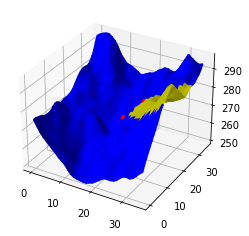

In [7]:
'''File to construct a pretty graph for windshelter'''

from distutils.ccompiler import new_compiler
import numpy as np
import math

# from yaml import DirectiveToken
from elevation import getElevationMatrix, rasterToImage, getRasterRGB
import mercantile
import basic_weather_calls
import wind_shelter
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go

import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def wind_shelter_all_data(lat,lng,zoom):
    #creating elevation matrix
    MAPBOX_TOKEN = 'pk.eyJ1IjoiY3Jpc3BpYW5tIiwiYSI6ImNsMG1oazJhejE0YzAzZHVvd2Z1Zjlhb2YifQ.cv0zlPYY6WnoKM9YLD1lMQ'

    tile_coords = mercantile.tile(lng, lat, zoom)
    elevation_mat = getElevationMatrix(MAPBOX_TOKEN, tile_coords.z, tile_coords.x, tile_coords.y)
    #finding wind direction at coords
    direction = np.pi/180*basic_weather_calls.wind_direction(lat,lng)
    
    #print(direction)
    
    #initial values
    
    tolerance = 30*np.pi/180 #from first paper
    
    #calculation of cellsize
    latitude_radians = lat * math.pi / 180
    
    cellsize = abs(156543.03 * np.cos(latitude_radians) / (2 ** zoom))
    
    
    #using a max dist of 100m (from paper), calculating radius by zoom
    radius = math.ceil(400/cellsize)
    
    #creating mask for windward direction
    mask = wind_shelter.wind_shelter_prep(radius,direction,tolerance)
    
    #calculating wind shelter
    shelter, shelter_array = wind_shelter.shelter_index(elevation_mat,mask,radius,cellsize,array_return=True)
    
    return shelter,mask,shelter_array,direction


    

#using some coords from snowdon
lat = 53.068611
lon = -3.086643
zoom = 12
    
shelter_index,mask,shelter_array,direction = wind_shelter_all_data(lat,lon,zoom)


print(shelter_index)

print(direction)


#retrieving elevation matrix, windshelter function does something funny to it
MAPBOX_TOKEN = 'pk.eyJ1IjoiY3Jpc3BpYW5tIiwiYSI6ImNsMG1oazJhejE0YzAzZHVvd2Z1Zjlhb2YifQ.cv0zlPYY6WnoKM9YLD1lMQ'

tile_coords = mercantile.tile(lon, lat, zoom)
elevation_mat = getElevationMatrix(MAPBOX_TOKEN, tile_coords.z, tile_coords.x, tile_coords.y)

# Set up grid
nx = elevation_mat.shape[0]
ny = elevation_mat.shape[1]

mask_overlay = np.ones([nx,ny])

#finding the centre value of the mask
ctr_mask,coord_mask = wind_shelter.centervalue(mask_overlay)


#the mask is a (radius +1 by radius +1) array - we want to iterate from the (centre-radius,centre-radius)
#and reassign all the ones with zeros from the mask 

radius = (mask.shape[0]-1)/2

start_point_i = coord_mask-radius
start_point_j = coord_mask - radius

full_shelter_array = np.zeros([nx,ny])

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        i_index = int(start_point_i+i)
        j_index = int(start_point_j+j)
        mask_overlay[i_index,j_index]=mask[i,j]
        full_shelter_array[i_index,j_index] = shelter_array[i,j]
        

location = np.where(full_shelter_array==shelter_index)

defining_point = (location[0][0],location[1][0])






print(defining_point)
mask_overlay[coord_mask,coord_mask] = 2
mask_overlay[defining_point[0],defining_point[1]]=2
radius = int(radius)
print(coord_mask-radius)
# data = elevation_mat
data = elevation_mat[coord_mask-radius:coord_mask+radius,coord_mask-radius:coord_mask+radius]

mask_overlay = mask_overlay[coord_mask-radius:coord_mask+radius,coord_mask-radius:coord_mask+radius]

full_shelter_array = full_shelter_array[coord_mask-radius:coord_mask+radius,coord_mask-radius:coord_mask+radius]

location = np.where(full_shelter_array==shelter_index)

defining_point_crop = (location[0][0],location[1][0])

colour_tuple = ('y','b','r')
colors = np.empty((mask_overlay.shape[0],mask_overlay.shape[1]), dtype=str)

for i in range(mask_overlay.shape[0]):
    for j in range(mask_overlay.shape[1]):
        if mask_overlay[i,j]==0:
            colors[i,j]=colour_tuple[0]
        elif mask_overlay[i,j]==2:
            colors[i,j]=colour_tuple[2]
        elif mask_overlay[i,j]==1:
            colors[i,j]= colour_tuple[1]

#changing centre point so it can be a different color


x = range(data.shape[0])
y= range(data.shape[1])

fig = plt.figure()
ha = plt.axes(projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, data,facecolors=colors,linewidth=2)



u = -np.sin(direction)
v = -np.cos(direction)
grad = np.gradient(data)

w = np.sqrt(grad[0]**2+grad[1]**2+np.sqrt(grad[0]**2+grad[1]**2 )**2)

print(w[1].shape)
print(w[0].shape)



# ha.quiver(X, Y, data, u, v, w, length=2)

plt.show()


In [9]:
import seaborn as sns
palett = sns.color_palette("husl", n_colors=3).as_hex()
list(palett)
palett[2] = '#ff0000'

In [11]:
centre_mask,centre_coord_mask = wind_shelter.centervalue(mask_overlay)
print(centre_coord_mask)





18


In [12]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd

# Read data from a csv
# z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

# fig = go.Figure(data=[])

fig = go.Figure(data=[
    go.Surface(z=data, surfacecolor=mask_overlay, colorscale=palett),
    go.Scatter3d(x=centre_coord_mask, y=[centre_coord_mask, 20], z=[280, 290], mode='markers', markers=dict(color='red', size=10))])

fig.update_layout(title='Elevation and Wind Shelter', autosize=False,
                #   width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

ValueError: 
    Invalid value of type 'builtins.int' received for the 'x' property of scatter3d
        Received value: 18

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series